# Low-Level Analysis
Jana Bruses | janabruses@pitt.edu | University of Pittsburgh | Apr. 3rd - ...

First analysis notebook of a series of two.\
Third notebook of the project, after [Data-Parsing-Exploratory-Analysis-2](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb).

This analysis aims to quantify the linguistic markers of Catalan language substitution by measuring specific changes over time.\
The following exploration looks at lower-level linguistic symptoms (morphological, syntactic, lexical, and semantic).\
For higher-level/text characteristics that could indicate increasing convergence with Spanish check the notebook [Analysis-2-TextLevel](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Analysis-2-TextLevel.ipynb).\
The data colection and dataframe building process used for this analysis can be found in [Data-Parsing-Exploratory-Analysis-2](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/blob/main/Data-Parsing-Exploratory-Analysis-2.ipynb), that now will be loaded from their pickled form as our data.

Contents of this analysis notebook:\
**0** [Recap Data Analysis](#Quick-recap-analysis-to-refresh-our-memory)\
**1** [Loss of Word Classes](#1.-Loss-of-word-classes---pronoms-febles)\
**2** [Time/Space Lexicon](#2.-Time-and-space-lexicon-modification)\
**3** [Syntactic Restructuring](#3.-Syntactic-restructuring)\
**4** [Low-Level Analysis Conclusion and Findings](#4.-Low-Level-Analysis-Conclusion-and-Findings) 

In [274]:
# loading libraries
import pandas as pd
import re
import stanza
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [275]:
# loading the pickled complete dataframe 
tokscomplete_df = pd.read_pickle("tokcomplete_df.pkl")

In [276]:
# keeping only the columns we are interested in
tokscomplete_df = tokscomplete_df[["Year", "Line_id", "Text", "Text_len", "toks", "Len_toks"]]

### Quick recap analysis to refresh our memory

In [277]:
# quick recap data on the dataframe
print("There are", tokscomplete_df.shape, "pieces of text")
print("The total of tokens in the dataframe is:", tokscomplete_df["Len_toks"].sum())

There are (75480, 6) pieces of text
The total of tokens in the dataframe is: 3063943


In [278]:
tokscomplete_df.describe()

,Year,Text_len,Len_toks
count,75480.000000,75480.000000,75480.000000
mean,2008.832658,187.739043,40.592780
std,3.064608,611.358140,122.724208
min,1860.000000,0.000000,0.000000
25%,2008.000000,38.000000,9.000000
50%,2009.000000,95.000000,21.000000
75%,2010.000000,222.000000,48.000000
max,2022.000000,73881.000000,14727.000000


**Comment:**\
The total amount of data in tokens we are working with is about three million tokens.\
The oldest text we have data from is from 1860, while the most recent is from 2022.\
The distribution of the data leans more towards recent years as the mean date of pieces of text is 2008.

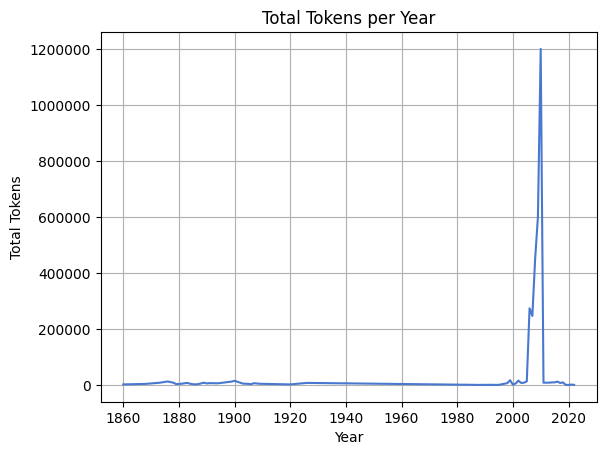

In [279]:
# taking a look at the uneven distribution of the data for clarification
toks_per_year = tokscomplete_df.groupby("Year")["Len_toks"].sum()
toks_per_year = toks_per_year.sort_index()

# plotting tokens per year with years on the x-axis
toks_per_year.plot(kind="line")
plt.xlabel("Year")
plt.ylabel("Total Tokens")
plt.title("Total Tokens per Year")
plt.grid(True)
plt.gca().yaxis.set_major_formatter(lambda x, _: int(x))
plt.show()

**A note on the following analysis**\
Because of the difference in data sizes for each year, and in the distribution of our data, all counts will be evaluated considering the size of the amount of tokens of the year they belong to.\
To do so we will work always considering the proportion of data this counts represent in the overall data amount for the respective year, as a percentage.

With this consideration in mind we will now start the analysis:

## 1. Loss of word classes - pronoms febles

Following Dr. Junyent's idea that one of the key warnings of a language endangerement's is the loss of word classes we will conduct a frequency exploration of Pronoms Febles as our target word class. Specifically we will take a close look at the **"hi"** pronoun that can't be found in Spanish and might be dropped to copy Spanish's structures.\
"en" is another "pronom feble" not found in Spanish, however, as "en" is a word that has many other functions and would be harder to identify we will focus on "hi".\
The following examples and explanations on the pronoun "hi" have been guided by, taken and translated from [els-pronoms-son-vida](https://www.vilaweb.cat/noticies/els-pronoms-son-vida/), an article on the lead online Catalan's newspaper written by the Catalan philologist Jordi Badia i Pujol, who does an amazing job presenting "en" and "hi", cornerstones of Catalan, naming them "the life of Catalan."

(Badia, J. (2024, 26 de març). Els pronoms són vida. VilaWeb. https://www.vilaweb.cat/noticies/els-pronoms-son-vida/)

### Brief grammatical background for **"hi"**

It's a pronoun is used to replace complements starting with any preposition other than "de" (which would be replaced by "en")\
For example:\
Demà anem al pis. ---> Demà **hi** anem\
*We are going to the flat tomorrow ---> We are going "to it" tomorrow\
"hi" = al pis/*the flat*

Some examples of some of the most common situations in which this pronoun is being forgotten:
* *Sé que t’esperen a la piscina, però no **ø** pots anar -> [...], no **hi** pots anar
* Demà hi ha la festa, però jo **ø** no estaré -> [...], però jo no **hi** seré
* Sí que **ø** està, però ara no **ø** es pot posar -> Sí que **hi** és, però ara no **s’hi** pot posar
* Avui pot haver **ø** una desgràcia -> Avui pot **haver-hi** una desgràcia

Looking at these examples, we can see that what we need to scan the text for is:
- "hi"\
  when the clitic pronom feble is a proclitic
- "-hi"\
  when it is an enclitic

In [280]:
# creating a column with the lowercased token list 
tokscomplete_df["toks_low"] = tokscomplete_df["toks"].apply(lambda x: [w.lower() for w in x])

In [281]:
# creating a function to find pronom febles and their context 
def get_pf(tok_list, pf_target):
    '''
    takes in a token list and a pronom feble as target
    returns a list of 3 element tupples: 
    (preceding word, target pronom feble, following word)
    '''
    found = [(tok_list[tok_list.index(word)-1], word, tok_list[tok_list.index(word)+1]) 
             for word in tok_list if re.fullmatch(pf_target, word) and tok_list.index(word) < len(tok_list)-1]
    return set(found)

In [282]:
# finding the "hi" pronom feble
tokscomplete_df["hi"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"hi")) #proclitic
tokscomplete_df["-hi"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r".*-hi")) #enclitic

In [283]:
# initially the idea was to also scan for "en" but due to its multiple functions, this section has been commented out
#tokscomplete_df["en"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"en"))
#tokscomplete_df["se'n"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"se'n"))
#tokscomplete_df["n'"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r"n[’']"))
#tokscomplete_df["-ne"] = tokscomplete_df["toks_low"].apply(lambda x: get_pf(x, r".*-ne"))

In [284]:
# taking a look at the dataframe after these new columns
tokscomplete_df.head()

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{}
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{}
2,1900,Discurs-pròlec,Discurs-prolec Llegit en la societat mèdic-far...,73881,"[Discurs-prolec, Llegit, en, la, societat, mèd...",14727,"[discurs-prolec, llegit, en, la, societat, mèd...","{(pròu, hi, gosaria)}",{}
3,1894,Discurs,"Senyors excelentissims, senyors:\n\nQuan rebí ...",29393,"[Senyors, excelentissims, ,, senyors, :, Quan,...",5814,"[senyors, excelentissims, ,, senyors, :, quan,...","{(que, hi, ha)}",{}
4,1903,Discurs,"Senyors:\n\nSembla que era air, y fa ja uns qu...",26577,"[Senyors, :, Sembla, que, era, air, ,, y, fa, ...",4774,"[senyors, :, sembla, que, era, air, ,, y, fa, ...","{(que, hi, ha)}","{(a, assegurar-los-hi, un)}"


**Comment:** We can find examples of both "hi" and "-hi" pronouns that have been found in the texts in the last two columns of these first 5 rows. Looking a the contexts, we can also see that these are indeed, pronoms febles. 

In [285]:
# adding a count column for "hi" pronouns per text line
tokscomplete_df["hi_count"] = tokscomplete_df["hi"].apply(len)+tokscomplete_df["-hi"].apply(len)

In [286]:
tokscomplete_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1


**Comment:** Now that we have found the "hi" pronouns in the texts and have the raw count per text, let's analyze it and plot it for a more visual output. 

In [287]:
# divinding "hi" count by the token count per text piece
# multiplying by 100 to get the percentage
tokscomplete_df["hi_percent"] = tokscomplete_df.apply(
    lambda row: (row["hi_count"] / row["Len_toks"]) * 100 if row["Len_toks"] > 0 else 0,
    axis=1
)

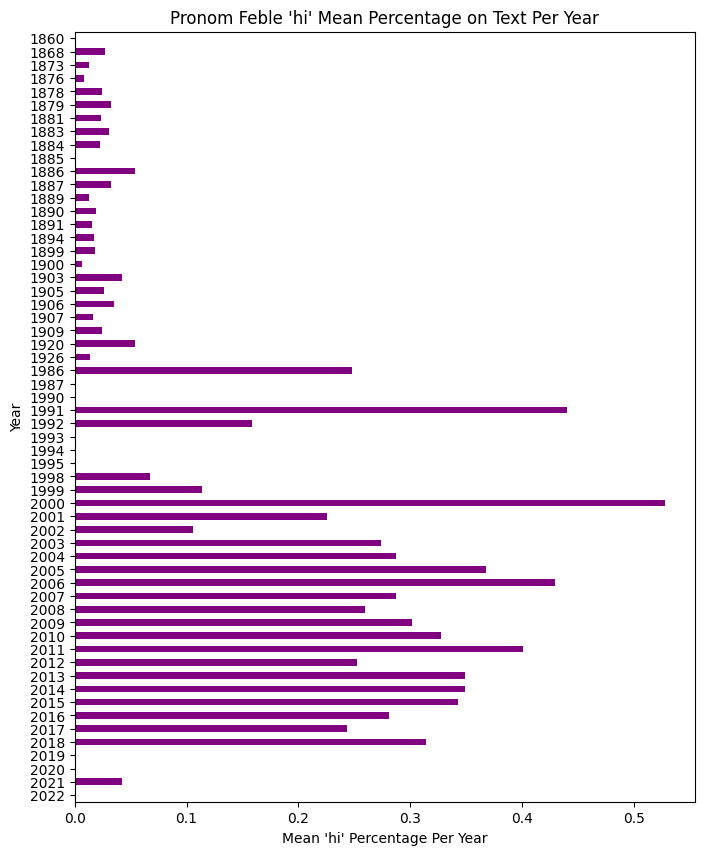

In [288]:
# plotting the "hi" distribution per year
# grouping by year
# getting average hi percentage per text per year
hi_grouped = tokscomplete_df.groupby("Year")["hi_percent"].mean()

plt.figure(figsize=(8, 10))
hi_grouped.plot(kind="barh", color="purple")
plt.xlabel("Mean 'hi' Percentage Per Year")
plt.ylabel("Year")
plt.title("Pronom Feble 'hi' Mean Percentage on Text Per Year")
plt.gca().invert_yaxis()  # inverting axis so it is from oldest to most recent
plt.show()

In [289]:
# correlation year-hi_percentages
rho_hi, p_hi = spearmanr(tokscomplete_df["Year"], tokscomplete_df["hi_percent"])
print(f"Hi% - rho: {rho_hi:.3f}, p-value: {p_hi:.4f}")

Hi% - rho: -0.014, p-value: 0.0001


**Conclusion on Pronoms Febles:**\
Both the rho result and the graph show us that there is no clear tendency in the use of the pronoun "hi". There's drops and increases through out the whole time-span and no clear increase or decrease of the use of "hi". However, I'm not really convinced with this representation, or the percentages idea, so I might change the plot later on.

In [290]:
# saving new columns in a modified pickle of the dataframe
tokscomplete_df.to_pickle("LowAnalysisDF.pkl")

## 2. Time and space lexicon modification

### 2.1 Directional distinction in anar and venir

Catalan, like in English, makes a clear distinction in **motion** towards and away from the speaker.\
For motions **away from the speaker** we use **"anar"**.\
For motions **towards the speaker** **"venir"** is used.\
This distinction is less strict in Spanish, therefore, seeing one of the two verbs increase in use taking over contexts where the other was usually used, would be indicating language substitution.Following another or Junyent's hypothesis, the distinction might be disolving, leading to an increase in use of one of the two verbs. 

**Note on the approach:**\
Since the verbs "anar" and "venir" have lots of conjugations for tense, person and number, it would be quite tedious to try to list all of them in our hunt for these in the texts. Therefore, we will use the POS tags and lemmatization from Stanza's Catalan model. That way, we'll be able to find all "anar" and "venir" forms just by looking for the lemma. 

In [291]:
# creating nlp pipeline to tokenize the sentences in catalan 
#lang = ca(catalan)
nlp = stanza.Pipeline(lang="ca", processors="tokenize,mwt,pos,lemma")

2025-04-06 22:15:41 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-04-06 22:15:41 INFO: Downloaded file to /Users/janabruses/stanza_resources/resources.json
2025-04-06 22:15:42 INFO: Loading these models for language: ca (Catalan):
| Processor | Package         |
-------------------------------
| tokenize  | ancora          |
| mwt       | ancora          |
| pos       | ancora_nocharlm |
| lemma     | ancora_nocharlm |

2025-04-06 22:15:42 INFO: Using device: cpu
2025-04-06 22:15:42 INFO: Loading: tokenize
2025-04-06 22:15:42 INFO: Loading: mwt
2025-04-06 22:15:42 INFO: Loading: pos
2025-04-06 22:15:43 INFO: Loading: lemma
2025-04-06 22:15:44 INFO: Done loading processors!


In [292]:
# creating a 2 trial verb sequences containing various conjugations of the verbs "anar" (to go) and "venir" (to come)
# checking for lemmatization
# verb_doc = nlp (infinitive, 1.sing.prs, 2.sing.pst "perfet",  1.plur.pst "imperfet", 2.plur.pst simple, 3.plur.fut 
anar_doc = nlp("anar, vaig, has anat, anàvem, anàreu, aniran")
venir_doc = nlp("venir, vinc, has vingut, veníem, vinguéreu, vindran")
print("Lemmatization anar:")
print(*[f"word: {word.text+" "}\tlemma: {word.lemma}" for sent in anar_doc.sentences for word in sent.words], sep="\n")
print()
print("Lemmatization venir:")
print(*[f"word: {word.text+" "}\tlemma: {word.lemma}" for sent in venir_doc.sentences for word in sent.words], sep="\n")

Lemmatization anar:
word: anar 	lemma: anar
word: , 	lemma: ,
word: vaig 	lemma: anar
word: , 	lemma: ,
word: has 	lemma: haver
word: anat 	lemma: anar
word: , 	lemma: ,
word: anàvem 	lemma: anar
word: , 	lemma: ,
word: anàreu 	lemma: anàreu
word: , 	lemma: ,
word: aniran 	lemma: anar

Lemmatization venir:
word: venir 	lemma: venir
word: , 	lemma: ,
word: vinc 	lemma: venir
word: , 	lemma: ,
word: has 	lemma: haver
word: vingut 	lemma: venir
word: , 	lemma: ,
word: veníem 	lemma: venire
word: , 	lemma: ,
word: vinguéreu 	lemma: vinguér
word: , 	lemma: ,
word: vindran 	lemma: venir


**Comment on lematization:** The lemmatization worked out well overall, we find the correct lemma "anar" and "venir" for almost all of the conjugations we've tried changing in person, number and tense. The only mistake is with the past simple form, which is usually known more of as an archaic form. Still we will take that into account and look for "anar" and "venir" with "anar", "anàreu" and "venir", "vinguér", "venire" respectively. It still reduces our list very much and makes the process easier. 

**Lemmatization process:**
The documents were lemmatized using pitt supercomputing (CRC), as running it in my local machine would have been an incredibly long, maybe even impossible, process.\
The process correponds to the following line:

In [293]:
# tokscomplete_df["Lemmas"] = tokscomplete_df["Text"].apply(lambda doc: [word.lemma for sent in nlp(doc).sentences for word in sent.words])

The following commented out code and slurm file were used and can be found in the scripts folder in this repository with their respective extensions. [(link to scripts)](https://github.com/Data-Science-for-Linguists-2025/Linguistic-Markers-Catalan-Substitution/tree/main/scripts)\
After the lemmatization the resulting dataframe containing a row of text lemmas list was pickled.

In [294]:
python_script= '''
import pandas as pd
import stanza

low_analysis_df = pd.read_pickle("LowAnalysisDF.pkl")
nlp = stanza.Pipeline(lang='ca', processors='tokenize,mwt,pos,lemma')
anar_doc = nlp("anar, vaig, has anat, anàvem, anàreu, aniran")
venir_doc = nlp("venir, vinc, has vingut, veníem, vinguéreu, vindran")
print("Lemmatization anar:")
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in anar_doc.sentences for word in sent.words], sep='\n')
print()
print("Lemmatization venir:")
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in venir_doc.sentences for word in sent.words], sep='\n')

low_analysis_df["Lemmas"] = low_analysis_df["Text"].apply(lambda doc:
                                                          [word.lemma for
                                                           sent in nlp(doc).sentences
                                                           for word in sent.words])
'''

In [295]:
slurm_file = '''
#!/usr/bin/env bash

#SBATCH --job-name=proj_lemmatization
#SBATCH --output=lemmatization.out
#SBATCH --nodes=1
#SBATCH --ntasks=3
#SBATCH --partition=smp
#SBATCH --cluster=smp
#SBATCH --mem-per-cpu=16000
#SBATCH --time=180

module load python/ondemand-jupyter-python3.11
python lemmatization_script.py
'''

In [296]:
# reading in the dataframe with lemma list column
lemma_df = pd.read_pickle("lemmaComplete.pkl")

In [297]:
# checking the new column
lemma_df.head(3)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i..."
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s..."
2,1900,Discurs-pròlec,Discurs-prolec Llegit en la societat mèdic-far...,73881,"[Discurs-prolec, Llegit, en, la, societat, mèd...",14727,"[discurs-prolec, llegit, en, la, societat, mèd...","{(pròu, hi, gosaria)}",{},1,0.006790,"[Discurs-prolec, llegit, en, el, societat, mèd..."


**Comment:** Now that we have lemmatized our text we will hunt for instances in any conjugation of "anar" and "venir", and see if we can find any trends of one taking over the other's use. 

In [298]:
# counting instances of anar and venir in each of the lemma lists for each text piece
lemma_df["Anar_count"] = lemma_df["Lemmas"].apply(lambda x: x.count("anar") + x.count("anàreu"))
lemma_df["Venir_count"] = lemma_df["Lemmas"].apply(lambda x: x.count("venir") + x.count("vinguér") + x.count("venire"))

In [299]:
lemma_df.head(3)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas,Anar_count,Venir_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0
2,1900,Discurs-pròlec,Discurs-prolec Llegit en la societat mèdic-far...,73881,"[Discurs-prolec, Llegit, en, la, societat, mèd...",14727,"[discurs-prolec, llegit, en, la, societat, mèd...","{(pròu, hi, gosaria)}",{},1,0.006790,"[Discurs-prolec, llegit, en, el, societat, mèd...",19,5


In [300]:
# grouping "anar" and "venir" counts per year
# dividing by text size
# multiplying by 100 to get percentage of anar and venir on the year's tokens
anar_df = (lemma_df.groupby("Year")["Anar_count"].sum()/lemma_df.groupby("Year")["Len_toks"].sum()*100).reset_index()
venir_df = (lemma_df.groupby("Year")["Venir_count"].sum()/lemma_df.groupby("Year")["Len_toks"].sum()*100).reset_index()

In [301]:
# creating a mini year grouped dataframe with the percentages per year to plot it
anar_df = anar_df.rename(columns ={"Year": "Year", 0:"Anar%"})     # creating dataframe of "anar" percentage off the tokens per year
venir_df = venir_df.rename(columns ={"Year": "Year", 0:"Venir%"})  # creating dataframe of "venir" percentage off the tokens per year
direction_df = pd.merge(anar_df, venir_df, on="Year")              # merging the two mini year-grouped percentage dataframes in a single one

In [302]:
# checking the resulting mini dataframe first 2 years
direction_df.head(2)

,Year,Anar%,Venir%
0,1860,0.000000,0.104275
1,1868,0.026759,0.347873


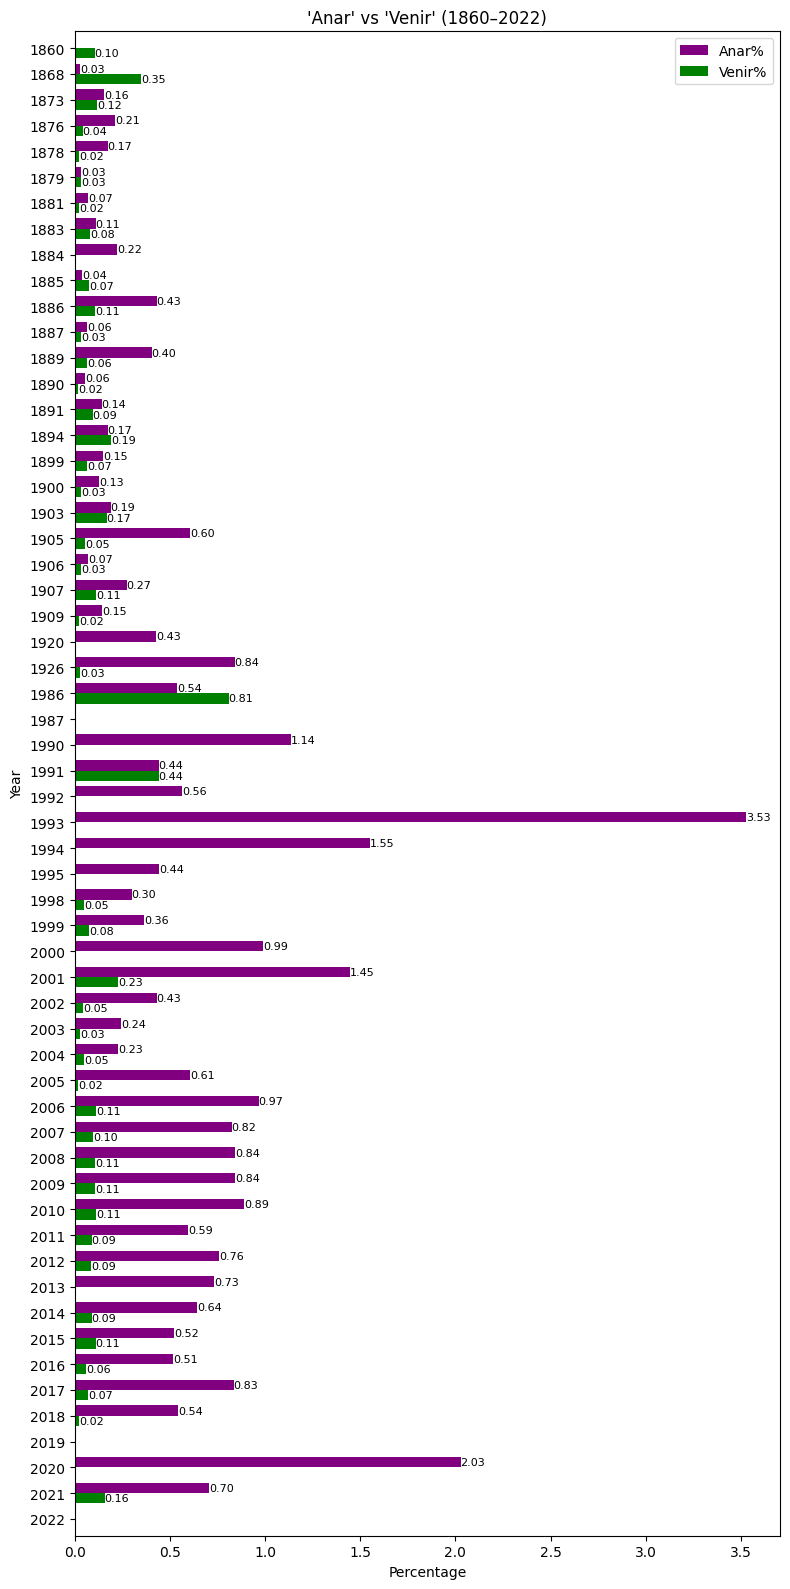

In [303]:
# plotting anar vs venir
ax = direction_df.plot.barh(
    y=["Anar%", "Venir%"],
    x="Year",
    figsize=(8, 16),  
    width=0.8,
    color = ["purple", "green"]
)

# adding value annotations
for p in ax.patches:
    w = p.get_width()
    if w > 0:
        ax.annotate(f"{w:.2f}", 
                    (w, p.get_y() + p.get_height() / 2),
                    va="center", ha="left", fontsize=8)

ax.set_title("'Anar' vs 'Venir' (1860–2022)", fontsize=12)
ax.set_xlabel("Percentage")
ax.set_ylabel("Year")
ax.invert_yaxis()  # from olderst to most recent
plt.tight_layout()
plt.show()

In [304]:
from scipy.stats import spearmanr

# correlation year-percentages
rho_anar, p_anar = spearmanr(direction_df["Year"], direction_df["Anar%"])
rho_venir, p_venir = spearmanr(direction_df["Year"], direction_df["Venir%"])
print(f"Anar% - rho: {rho_anar: 4f}, p-value: {p_anar:.4f}")
print(f"Venir% - rho: {rho_venir:.4f}, p-value: {p_venir:.4f}")

Anar% - rho:  0.565900, p-value: 0.0000
Venir% - rho: -0.0886, p-value: 0.5082


In [305]:
# difference through years
direction_df["Diff"] = direction_df["Anar%"] - direction_df["Venir%"]
rho_diff, p_diff = spearmanr(direction_df["Year"], direction_df["Diff"])
print(f"Diferència (Anar% - Venir%) - rho: {rho_diff:.4f}, p-value: {p_diff:.4f}")

Diferència (Anar% - Venir%) - rho: 0.5594, p-value: 0.0000


**Conclusion here**\
The use of the verb "anar" (to go) increases significantly through out the years, while "venir" (to come,) does not show any significant change.\
The difference in the use of the two verbs, clearly increases with the increase in the use of "anar". This could suggest that anar is taking over some of the situations in which venir used to be used, as there is a significant tendency in the difference of 0.55, and in the increase of "Anar" of 0.56. However, since "Venir" does not experience any drop, the meaning and functions of "Anar" might just be getting extended in other ways, not necessarly taking over the function of "Venir".

### 2.2 Shift from "perifràstic" past to simple past

**A bit of grammar background on the perifrastic past:**

The Perifrastic Past in Catalan is a verb tense used to express past tense actions that were done in the past and have been finished.\
It is characteristic and a cornestone of Catalan as no neolatin language uses a Perifrastic Past.\
It has the same value and sense as Simple Past. In English *"I went"*.\
It is formed with the auxiliary form of the verb "anar" and the main verb in its infinitive form.\
Anar (to go) is conjugated in the present tense.
| **Pattern:** | **(subj)** | **present tense anar** | **main verb inf** |
|:---|:---|:---|:---|
|(1st Sing.) | Jo	| vaig | parlar |
|(2nd Sing.) | Tu	| vas/vares | parlar |
|(3rd Sing.) | Ell/Ella | va | parlar |
|(1st Plur.) | Nosaltres | vam/vàrem | parlar |
|(2nd Plur.) | Vosaltres | vau/vàreu | parlar |
|(3rd Plur.) | Ells / Elles |	van/varen |	parlar |

\
Another note, that will be helpful in our search for this tense is that all infinitives in Catalan belong to one of 3 conjugations that have a particular ending.\
Inifitive form verbs of the **first conjugation** finish in **"-ar"**, as the previous example "parlar" or for another example "menjar".\
**Second conjugation** verbs infinitives end in **"-er"** like "saber" or **"-re"** like "pretendre".\
**Third conjugugation** infinitives end in **"-ir"** like "dormir".

All forms follow this rule and there are no irregular forms.

Given the strong regularity let's go straight into takeling the perifrastic past hunt.

In [306]:
# creating a function to find pronom febles and their context
def get_pstperif(text):
    '''
    takes in a text and returns a list of found "passat perifrastic" forms in the text
    '''
    # regex breakdown:
    # \b -> word boundary
    # (?:vaig|vas|vares|va|vam|vàrem|vau|vàreu|van|varen) -> has to match one of the auxiliar forms 
    # \s+ -> zero or more whitespace characters (the space between the aux and main verb)
    # (?:ar|er|re|ir) -> has to match one of the infinitive endings
    # this pattern ensures we are capturing only compound forms and they are "Passat Perifrastic" as their aux is "anar"
    target = r"\b(?:vaig|vas|vares|va|vam|vàrem|vau|vàreu|van|varen)\s+\w+(?:ar|er|re|ir)"
    found = re.findall(target, text, flags=re.IGNORECASE)
    return found

In [307]:
# getting all passat perifrastics forms as a list and storing them in a column
lemma_df["PstPerif"] = lemma_df["Text"].apply(get_pstperif)

In [308]:
# counting the passat perifrastic forms per row and storing that count as a new column
lemma_df["Pstp_count"] = lemma_df["PstPerif"].apply(len)

In [309]:
# checking the new columns
lemma_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas,Anar_count,Venir_count,PstPerif,Pstp_count
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2,"[va dedicar, va erigir, va fer, va interrogar,...",35
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0,"[vaig ésser, vaig començar, vaig trobar, vàrem...",4


**Comment:** We have now found and counted all the Passat Perifrastic forms in the texts stored in the "PstPerif" column and counted on the "Pstp_count" column. We will now explore the counts and years to see if there is a drop in the use of Passat Perifrastic that would portray a shift towards other tenses, likely to the influence of other romance languages.\
To analyze the count since it is heavly dependent on text length, we will create a new column with the percentage of Passat Perifrastic from the total tokens of the text piece. We will then use that percentage instead of the raw count to analyze the progression over time.

In [310]:
# divinding "hi" count by the token count per text piece
# multiplying by 100 to get the percentage
lemma_df["Pstp_percent"] = lemma_df.apply(
    lambda row: (row["Pstp_count"] / row["Len_toks"]) * 100 if row["Len_toks"] > 0 else 0,
    axis=1
)

In [311]:
lemma_df.head(2)

,Year,Line_id,Text,Text_len,toks,Len_toks,toks_low,hi,-hi,hi_count,hi_percent,Lemmas,Anar_count,Venir_count,PstPerif,Pstp_count,Pstp_percent
0,1926,Discurs llegit per... donar a conèxer la perso...,"L'home que per amor al estudi, impulsat per un...",37497,"[L', home, que, per, amor, al, estudi, ,, impu...",7267,"[l', home, que, per, amor, al, estudi, ,, impu...","{(n', hi, hagi)}",{},1,0.013761,"[el, home, que, per, amor, a, el, estudi, ,, i...",61,2,"[va dedicar, va erigir, va fer, va interrogar,...",35,0.481629
1,1920,Parlament llegit en la festa inaugural de l'Or...,"Cantaires de la Garriga, Senyores i senyors:\n...",9253,"[Cantaires, de, la, Garriga, ,, Senyores, i, s...",1865,"[cantaires, de, la, garriga, ,, senyores, i, s...","{(m', hi, vaig)}",{},1,0.053619,"[Cantaires, de, el, Garriga, ,, Senyores, i, s...",8,0,"[vaig ésser, vaig començar, vaig trobar, vàrem...",4,0.214477


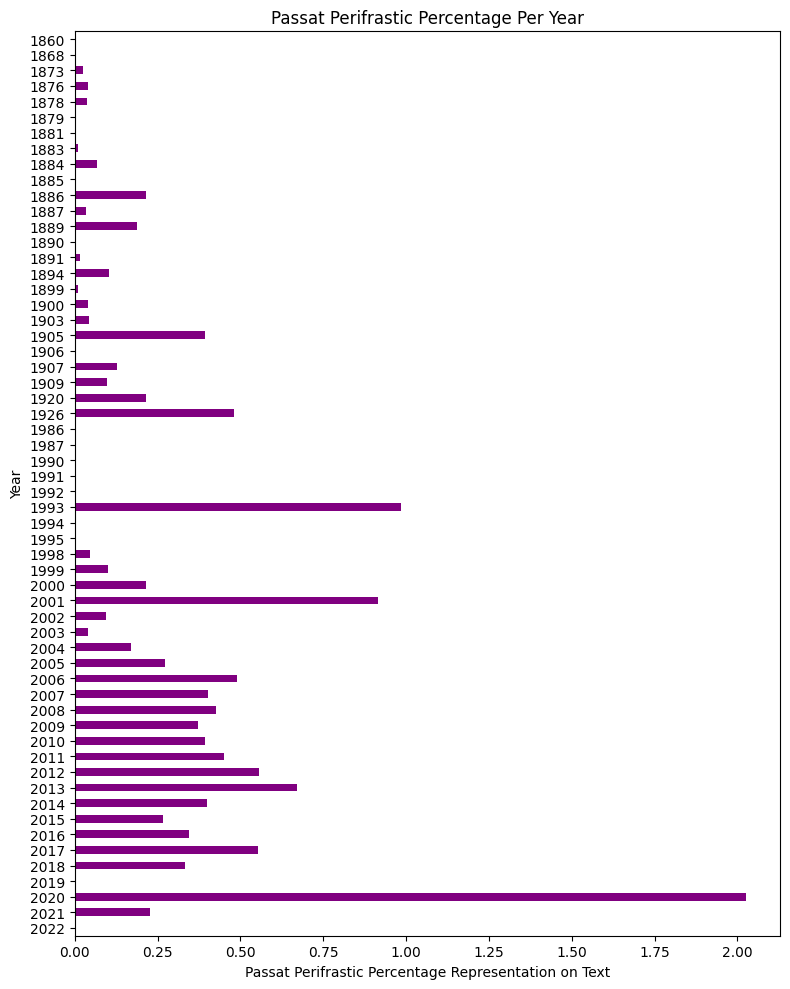

In [312]:
# grouping by year
# getting mean percentage of hi per text per year
df_grouped = lemma_df.groupby("Year")["Pstp_percent"].mean()

plt.figure(figsize=(8, 10))
df_grouped.plot(kind="barh", color="purple")
plt.xlabel("Passat Perifrastic Percentage Representation on Text")
plt.ylabel("Year")
plt.title("Passat Perifrastic Percentage Per Year")
plt.gca().invert_yaxis()  # Opcional, per invertir l'ordre de les etiquetes
plt.tight_layout()
plt.show()

In [313]:
# correlation year-hi_percentages
rho_pstp, p_pstp = spearmanr(lemma_df["Year"], lemma_df["Pstp_percent"])
print(f"Passat Perifràstic% - rho: {rho_pstp:.4f}, p-value: {p_pstp:.4f}")

Passat Perifràstic% - rho: -0.0202, p-value: 0.0000


**Conclusion**\
We could already see with the graph, and can suport with the rho result that there is no clear tendency in the use of Passat Perifràstic through out the years, there are sudden increases and decreases that do not show any clear pattern. 

### 2.3 Pronominalization of movement verbs

## 3. Syntactic restructuring

### 3.1 Tenir que vs haver de

## 4. Low-Level Analysis Conclusion and Findings